---
title: "Theory of RL III: Dynamic Programming"
date: "2021-04-29"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

Dynamic programming (DP) provides algorithms for **solving the RL problem given that a perfect model of the environment is available**. That is, assuming full access to the MDP, DP **allows us to obtain optimal policies by finding the optimal value functions**, $v_*$ or $q_*$, that satisfy the Bellman optimality equations. As we have noted before, having full access to the MDP is not realistic when we face more complex problems. Nonetheless, DP provides the **theoretical underpinning for many RL algorithms** that try to approximate optimal solutions without perfect knowledge of an environment's dynamics and is therefore essential for working on RL problems.

Note that we assume that we deal with a finite MDP. In particular, we assume that the state set $\mathcal{S}$, action set $\mathcal{A}$, and reward set $\mathcal{R}$ of the environment are all finite and that its dynamics are given by a set of probabilities $p(s', r \ \vert \ s, a)$, for all $s \in \mathcal{S}$, $a \in \mathcal{A}(s)$, $r \in \mathcal{R}$, and $s' \in \mathcal{S^+}$. Still, it is possible to get approximate solutions for continuous problems with the same methods by quantizing the state and action spaces.

To apply the DP algorithms, we'll use two custom [gym](https://github.com/openai/gym) environments: `WalkEnv` and `LakeEnv`.

In `WalkEnv` the agent needs to reach the end (the rightmost state) of a corridor without falling into a hole (the leftmost state). Unfortunately, the corridor is slippery: the agent (starting in the middle) only moves in the intended direction with probability $1/2$. With probability $1/3$ the agent stays in the same state, and with probability $1/6$ the agent trips and falls in the opposite direction.

In [ ]:
import numpy as np
import gym
import gym_walk

In [ ]:
rng = np.random.default_rng(1)

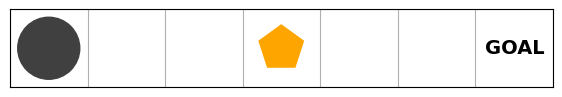

In [62]:
env = gym.make("SlipperyWalkFive-v0")
env.render(show_step=False)

In `LakeEnv` the problem is essentially the same, but slightly more complex: the agent has to cross a frozen lake without falling into a hole. Again, the ice is slippery so that the agent only moves in the intended direction with probability $1/3$. With probability $1/3$ each agent slides to the left or right of the current position (in relation to the intended direction). Let's see how this looks like:

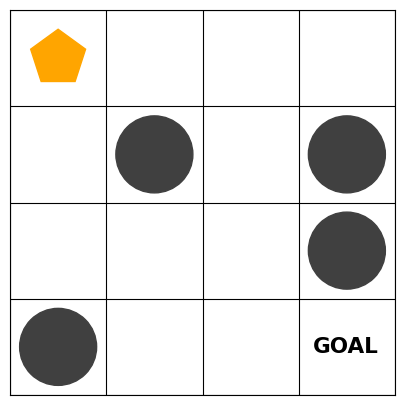

In [39]:
env = gym.make("FrozenLake4x4-v2")
env.render()

## Policy evaluation

Our first DP algorithm is **(iterative) policy evaluation**. The algorithm computes the state-value function $v_{\pi}$ for a given policy $\pi$, thereby solving the so-called **prediction problem**. Essentially, the algorithm uses the **Bellman equation as an update rule** for iteratively improving the approximation of the value function: 

$$v_{k+1}(s)= \mathbb{E}_{\pi} \left[ R_{t+1} + \gamma v_k (S_{t+1})\ \vert\ S_t = s \right] =\sum_a \pi(a \vert s) \sum_{s', r} p(s', r \vert s, a) \big[r + \gamma v_k(s')\big]$$

Let's go over what happens here. We start by initializing $v_0(s)$ for all $s \in \mathcal{S}$ arbitrarily, and to $0$ if $s$ is a terminal state. Then, at each iteration $k$, we compute a new approximation of each state-value by adding the expected immediate reward from that state and the estimated value of its successor state. This is called an **expected update** since it is based on an expectation over all possible transitions from that state. As $k$ approaches infinity, the algorithm converges to the true values (in practice we simply stop updating when the updates become negligible).

Importantly, at each iteration $k$ we use an estimate from the previous iteration, $v_{k-1}(s')$, to compute the new estimate $v_k(s)$. Using an estimate when calculating an estimate is a technique called **bootstrapping** that commonly appears in RL.

### Implementation

Before we look at a possible implementation of the policy evaluation algorithm, we first need to introduce the transition probability matrix `prob` and the reward matrix `reward`.

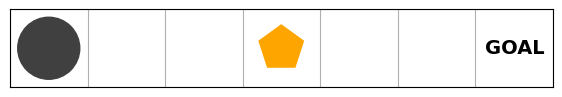

In [63]:
env = gym.make("SlipperyWalkFive-v0")
LEFT, RIGHT = 0, 1
env.render(show_step=False)

In [41]:
with np.printoptions(precision=3):
    print(env.prob)

[[[1.    0.    0.    0.    0.    0.    0.   ]
  [1.    0.    0.    0.    0.    0.    0.   ]]

 [[0.5   0.333 0.167 0.    0.    0.    0.   ]
  [0.167 0.333 0.5   0.    0.    0.    0.   ]]

 [[0.    0.5   0.333 0.167 0.    0.    0.   ]
  [0.    0.167 0.333 0.5   0.    0.    0.   ]]

 [[0.    0.    0.5   0.333 0.167 0.    0.   ]
  [0.    0.    0.167 0.333 0.5   0.    0.   ]]

 [[0.    0.    0.    0.5   0.333 0.167 0.   ]
  [0.    0.    0.    0.167 0.333 0.5   0.   ]]

 [[0.    0.    0.    0.    0.5   0.333 0.167]
  [0.    0.    0.    0.    0.167 0.333 0.5  ]]

 [[0.    0.    0.    0.    0.    0.    1.   ]
  [0.    0.    0.    0.    0.    0.    1.   ]]]


The transition probability matrix `prob` shows the transition probabilities depending on the current state and action. For example, suppose that the agent is currently in state $5$ (the second state from the right). Look at the second row: if it chooses the action "RIGHT", it will reach the rightmost state with probability $0.5$, stay in the same state with probability $0.333$, and trip and fall backwards with probability $0.167$. Accordingly, the first row corresponds to the action "LEFT":

In [42]:
with np.printoptions(precision=3):
    print(env.prob[5])

[[0.    0.    0.    0.    0.5   0.333 0.167]
 [0.    0.    0.    0.    0.167 0.333 0.5  ]]


Now, suppose the agent fell into the hole (that is, it is in state $0$, the leftmost state). Since this is a terminal state, the agent cannot leave it. Regardless of the action, the transition is always to the same state with probability $1.0$.

In [43]:
with np.printoptions(precision=3):
    print(env.prob[0])

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


The transition probability matrix has the shape `(n_states, n_actions, n_states)`. For every state it shows the transition probabilities to the next states depending on the action.

The reward matrix `reward` has the same shape. For every state it shows the potential rewards depending on the action. In our case, we use a very simple reward scheme. The agent gets reward $1.0$ if it reaches the rightmost state. As we see below, this is only possible from state $5$ where the agent can intentionally reach the goal by taking the action "RIGHT" or unintentionally by tripping and falling backward when choosing "LEFT".

In [44]:
with np.printoptions(precision=3):
    print(env.reward)

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]


Together `prob` and `reward` represent complete knowledge of the environment. We can now turn our attention to a possible implementation of the policy evaluation algorithm:

In [45]:
#| code-fold: show

def policy_evaluation(pi, prob, reward, gamma=1., theta=1e-10):
    """
    Args:
        pi (np.ndarray): policy;
        prob (np.ndarray): transition probability matrix;
        reward (np.ndarray): reward matrix;
        gamma (float): discount factor;
        theta (float): accuracy threshold;
    
    Returns:
        value (np.ndarray): value function of the given policy;
    """
    n_states, n_actions = prob.shape[0], prob.shape[1]
    # Initialize the values to zero
    value = np.zeros(n_states)
    while True:
        # Keep track of the old values
        value_old = value.copy()
        # Loop over all states
        for state in range(n_states):
            # Get the transition probabilities for the given state and action (as determined by the given policy)
            prob_sa = prob[state, pi[state], :]
            # Get the possible rewards for the given state and action
            reward_sa = reward[state, pi[state], :]
            # Perform the update (we'll look at this step in detail below)
            value[state] = prob_sa.T.dot(reward_sa + gamma * value_old)
        # Break the loop if the update is below the threshold theta
        if np.all(np.abs(value - value_old) < theta):
            break
    return value

It is probably wise to look at the update `value[state] = prob_sa.T.dot(reward_sa + gamma * value_old)` in isolation. What happens here? Let's make up a simplified example. Suppose we are in state $0$ and, following our policy, choose the action $1$. First, we need to get the probabilities of all possible transitions by accessing `prob[0, 1, :]`. In our example that might simply be `[0.5, 0.5]`, that is, state $0$ and state $1$ are the only possible next states and equally likely. Next we need the possible rewards. `reward[0, 1, :]` gives `[2.0, 10.0]`, that is, we get the reward $2$ when we stay in the same state $0$ and reward $10$ when we transition to state $1$. Finally, suppose that our current value estimates are `[1.0, 1.0]` and we chose `gamma = 1.0`. Our update to the value of state $0$ would look like this: $0.5 * (2.0 + 1.0 * 1.0) + 0.5 * (10.0 + 1.0 * 1.0)$. To simplify this in the implementation above, we use the dot product (or inner product) operation.

We are now ready to apply the policy evaluation algorithm to our `WalkEnv` example. Let's use it to compare the value functions of three policies: `pi_left` which chooses "LEFT" in every state, `pi_right` which chooses "RIGHT" every time (logically, this is the optimal policy in this example), and `pi_random` which randomly picks a direction in each step.

In [46]:
pi_left = {state : LEFT for state in range(env.prob.shape[0])}
pi_right = {state : RIGHT for state in range(env.prob.shape[0])}
pi_random = {state : rng.choice(env.prob.shape[1]) for state in range(env.prob.shape[0])}
policies = {"pi_left": pi_left, "pi_right": pi_right, "pi_random": pi_random}

pi_left: 


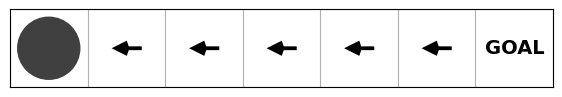

pi_right: 


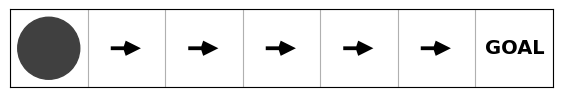

pi_random: 


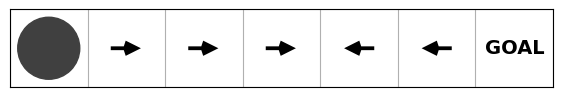

In [47]:
for pi_name, pi in policies.items():
    print(f"{pi_name}: ")
    env.render(policy=pi)

We can now determine the corresponding value functions with the help of our `policy_evaluation` algorithm:

In [48]:
for pi_name, pi in policies.items():
    value = policy_evaluation(pi, env.prob, env.reward)
    with np.printoptions(precision=3):
        print(f"{pi_name}:\t {value}")

pi_left:	 [0.    0.003 0.011 0.036 0.11  0.332 0.   ]
pi_right:	 [0.    0.668 0.89  0.964 0.989 0.997 0.   ]
pi_random:	 [0.    0.519 0.692 0.75  0.769 0.827 0.   ]


Again, it is probably easier to visualize the value functions.

pi_left: 


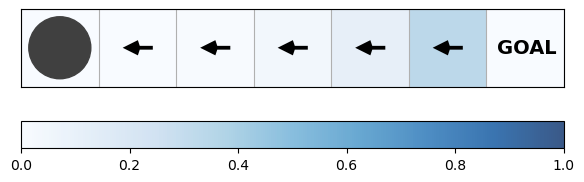

pi_right: 


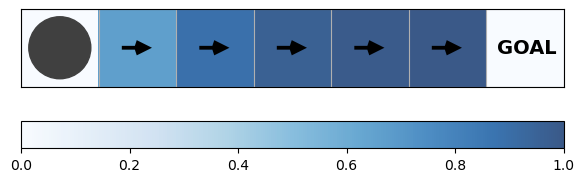

pi_random: 


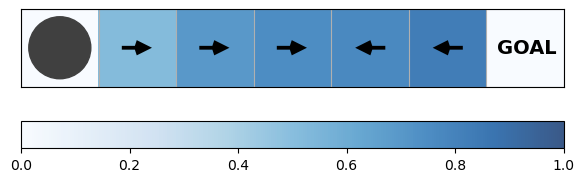

In [49]:
for pi_name, pi in policies.items():
    print(f"{pi_name}: ")
    env.render(policy=pi, values=policy_evaluation(pi, env.prob, env.reward))

## Policy Improvement

With policy evaluation we now have an algorithm to evaluate policies. How can we use it to obtain better policies, a task that is typically referred to as the **control problem**? Imagine we have computed the value function for an arbitrary (deterministic) policy $\pi$ and look at a specific state $s$. Since we know its value, we know how valuable it is to follow policy $\pi$ starting from this state. But is there actually an action $a \neq \pi(s)$ we could select now which puts us in a better position (assuming we still follow policy $\pi$ afterwards)? To answer this question, we can use the state-value function $v_{\pi}$ and the known dynamics of the MDP to **calculate the action-value function $q_{\pi}$**. The Q-function will tell us how valuable every state-action is, and if, for a given state, there is an action that is more valuable than the action determined by policy $\pi$. Then improving our policy is straightforward: in every state we just act greedily with respect to the action-value function (i.e. choose the actions with the highest values) and thereby obtain a new, improved policy $\pi'$.

This algorithm is called **policy improvement** and, as the name suggests, guarantees to always find an improved policy $\pi'$ (unless, of course, the policy $\pi$ is already optimal). Let's look at the math.

First, we need to compute $q_{\pi}(s,a)$:
$$
\begin{align}
q_{\pi}(s,a) & = \mathbb{E} \left[ R_{t+1} + \gamma v_{\pi} (S_{t+1})\ \vert\ S_t = s, A_t = a \right]\\
             & = \sum_{s', r} p(s', r \vert s, a) \left[ r + \gamma v_{\pi}(s') \right]
\end{align}
$$

Then, we obtain the improved policy $\pi'$ by taking the highest-valued action in every state. Ties can be broken arbitrarily or, in the stochastic case, by assigning each action a specific probability (while assigning zero probability to all actions that are not maximal):

$$\pi'(s) = \text{argmax}_a\ q_{\pi}(s,a)$$

### Implementation

In [50]:
#| code-fold: show

def policy_improvement(value, prob, reward, gamma=1.):
    """
    Args:
        value (np.ndarray): value function;
        prob (np.ndarray): transition probability matrix;
        reward (np.ndarray): reward matrix;
        gamma (float): discount factor;
    Returns:
        pi (np.ndarray): policy;
    """
    n_states, n_actions = prob.shape[0], prob.shape[1]
    # Initialize the action-values to zero
    q = np.zeros((n_states, n_actions))
    # Loop over all states
    for state in range(n_states):
        # Loop over all actions
        for action in range(n_actions):
            # Get the transition probabilities for the given state and action
            prob_sa = prob[state, action, :]
            # Get the rewards for the given state and action
            reward_sa = reward[state, action, :]
            # Determine the action-value
            q[state][action] = prob_sa.T.dot(reward_sa + gamma * value)
    # The improved policy uses the best available action in each state
    pi = np.argmax(q, axis=1)
    return pi

Let's say we want to improve the policy `pi_left` that we introduced above. We begin by computing the corresponding value function:

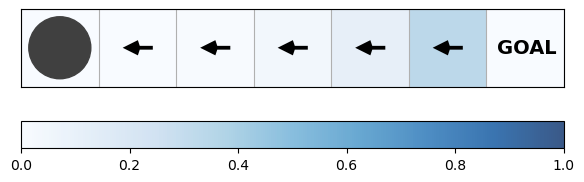

In [51]:
value_pi_left = policy_evaluation(pi_left, env.prob, env.reward)
env.render(policy=pi_left, values=value_pi_left)

Then we can apply the `policy_improvement` algorithm:

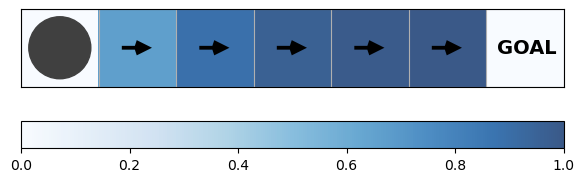

In [52]:
improved_pi = policy_improvement(value_pi_left, env.prob, env.reward)
env.render(policy=improved_pi, values=policy_evaluation(improved_pi, env.prob, env.reward))

In our small example, a single iteration of the policy improvement algorithm actually sufficed to obtain an optimal policy of always moving right (in this case, *the* optimal policy). But this is not guaranteed! Let's look at a more complex example:

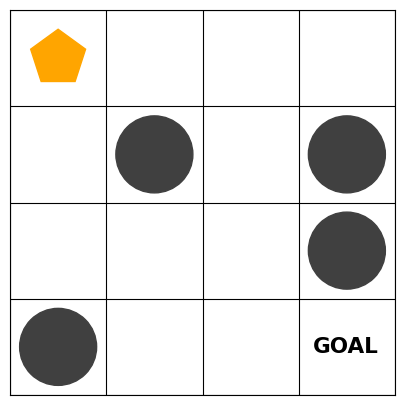

In [53]:
env = gym.make("FrozenLake4x4-v2")
env.render()

To say the least, the `pi_left` policy isn't a particularly wise choice for this problem. Let's see what happens when we apply our policy improvement algorithm:

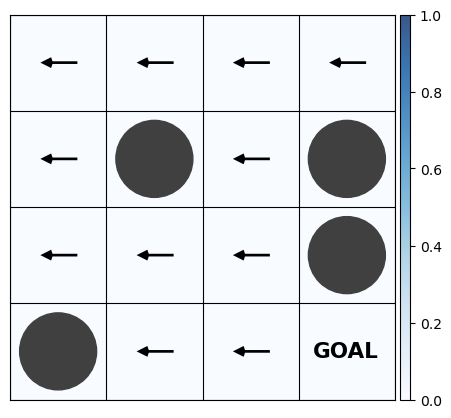

In [54]:
pi_left = {state : LEFT for state in range(env.prob.shape[0])}
value_pi_left = policy_evaluation(pi_left, env.prob, env.reward)
env.render(policy=pi_left, values=value_pi_left)

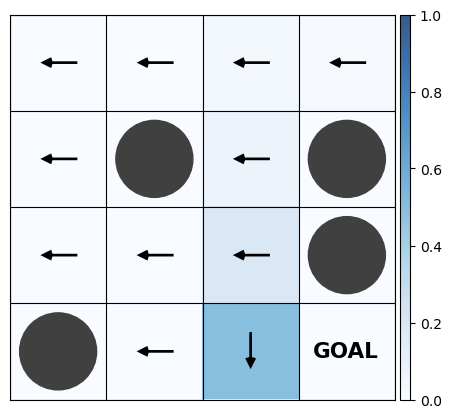

In [55]:
improved_pi = policy_improvement(value_pi_left, env.prob, env.reward)
value_improved_pi = policy_evaluation(improved_pi, env.prob, env.reward)
env.render(policy=improved_pi, values=value_improved_pi)

The new policy obtained by running policy improvement once is indeed better than the `pi_left` policy, but it is still far from optimal. What should we do now?

## Policy Iteration

We now have an algorithm that computes the value function for a given policy (policy evaluation) and an algorithm that uses the value function to obtain a strictly better policy (policy iteration). Since there is only a finite number of policies in a finite MDP, we can **obtain an optimal policy by alternating between policy evaluation and policy improvement** until the policy doesn't improve anymore. This process is called **policy iteration** and is **guaranteed to converge** to an optimal policy and the optimal value function regardless of the initial policy we choose.

$$\pi_0 \xrightarrow[]{\text{evaluate}} v_{\pi_0} \xrightarrow[]{\text{improve}}
\pi_1 \xrightarrow[]{\text{evaluate}} v_{\pi_1} \xrightarrow[]{\text{improve}}
\pi_2 \xrightarrow[]{\text{evaluate}}\ \dots\ \xrightarrow[]{\text{improve}}
\pi_* \xrightarrow[]{\text{evaluate}} v_*$$

### Implementation

Since we already have policy evaluation and policy improvement at our disposal, implementing the policy iteration algorithm is pretty straightforward:

In [56]:
#| code-fold: show

def policy_iteration(prob, reward, gamma=1., theta=1e-10):
    """
    Args:
        prob (np.ndarray): transition probability matrix;
        reward (np.ndarray): reward matrix;
        gamma (float): discount factor;
        theta (float): accuracy threshold;
    
    Returns:
        value (np.ndarray): optimal value function;
        pi (np.ndarray): optimal policy;
    """
    n_states, n_actions = prob.shape[0], prob.shape[1]
    # Randomly initialize a policy
    pi = np.random.choice(n_actions, n_states)
    while True:
        # Keep a copy of the old policy
        old_pi = pi.copy()
        # Compute the value function of the policy
        value = policy_evaluation(pi, prob, reward, gamma, theta)
        # Obtain an improved policy by running policy improvement
        pi = policy_improvement(value, prob, reward, gamma)
        # If the policy does not change anymore, we have obtained an optimal policy
        if np.array_equal(pi, old_pi):
            break
    return value, pi

Let's use `policy_iteration` to obtain an optimal policy for our `LakeEnv`:

In [57]:
env = gym.make("FrozenLake4x4-v2")

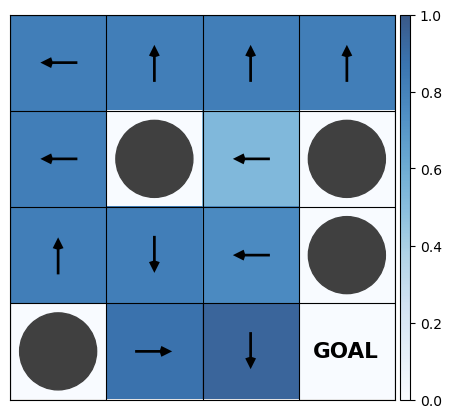

In [58]:
value_star, pi_star = policy_iteration(env.prob, env.reward)
env.render(values=value_star, policy=pi_star)

Interesting, isn't it?

## Value Iteration

One drawback of the policy iteration algorithm is that each of its iterations involves policy evaluation which usually requires an iterative computation itself. Fortunately, it turns out that exact convergence of the policy evaluation algorithm in every step of policy iteration is *not* necessary. Indeed, we can truncate policy evaluation without losing the convergence guarantees of policy iteration. If we **stop policy evaluation after a *single* sweep of the state space** (that is, after one update of each state), we obtain an algorithm called **value iteration** that can be expressed in a single equation effectively combining one sweep of policy evaluation and one sweep of policy improvement: 

$$
\begin{align}
v_{k+1}(s) & = \max_a \mathbb{E} \left[ R_{t+1} + \gamma v_k (S_{t+1})\ \vert\ S_t = s, A_t = a \right]\\
           & = \max_a \sum_{s', r} p(s', r \vert s, a) \left[ r + \gamma v_k(s') \right]
\end{align}
$$

For each state, we calculate the value of each action over all possible transitions as the sum of the immediate reward and the discounted estimate of the next state's value weighted by the probability of the transition. Then, we simply take the $\max$ over all actions. You may recognize that this is the same as **turning the Bellman optimality equation into an update rule** and identical to the policy evaluation update except for the $\max$ over all actions.

### Implementation

In [59]:
#| code-fold: show

def value_iteration(prob, reward, gamma=1., theta=1e-10):
    """
    Args:
        prob (np.ndarray): transition probability matrix;
        reward (np.ndarray): reward matrix;
        gamma (float): discount factor;
        theta (float): accuracy threshold;
    
    Returns:
        value (np.ndarray): optimal value function;
        pi (np.ndarray): optimal policy;
    """
    n_states, n_actions = prob.shape[0], prob.shape[1]
    # Initialize the values to 0
    value = np.zeros(n_states)
    while True:
        # Initialize the action-values to 0
        q = np.zeros((n_states, n_actions))
        # Loop over all states and actions
        for state in range(n_states):
            for action in range(n_actions):
                # This update step should be familiar by now
                prob_sa = prob[state, action, :]
                reward_sa = reward[state, action, :]
                q[state][action] = prob_sa.T.dot(reward_sa + gamma * value)
        # Stop iterating ff the changes to the value function become negligible
        if np.all(np.abs(value - np.max(q, axis=1)) < theta):
            break
        # Obtain the new state-values by taking the max over the action-values
        value = np.max(q, axis=1)
    # Define the policy accordingly
    pi = np.argmax(q, axis=1)
    return value, pi

Let's check whether value iteration indeed obtains the same result as policy iteration in our `LakeEnv` problem:

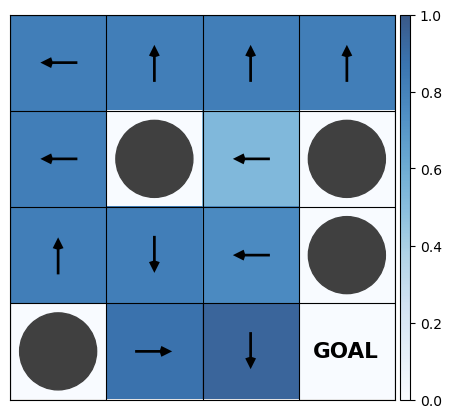

In [65]:
env = gym.make("FrozenLake4x4-v2")
value_PI, pi_PI = policy_iteration(env.prob, env.reward)
value_VI, pi_VI = value_iteration(env.prob, env.reward)

env.render(values=value_VI, policy=pi_VI)

In [61]:
#| code-fold: show

np.allclose(value_PI, value_VI)

True

## Generalized Policy Iteration

In both algorithms presented above, the **interaction of two competing processes** is responsible for obtaining an optimal policy: estimating the value function of a policy (**policy evaluation**), and deriving a policy that is greedy with respect to the current value function (**policy improvement**). Both processes essentially create a moving target for each other and only stabilize when an optimal policy and the optimal value function have been found. This general pattern is called **generalized policy iteration** (GPI). Policy iteration and value iteration, like most methods in RL, are only two specific realizations of this pattern: while we wait for the convergence of policy evaluation in each step of policy iteration, we merely perform a single update in value iteration. There are many other possible approaches: for example, doing multiple iterations of policy evaluation in between each step of policy improvement can lead to faster convergence. Also, it is possible to asynchronously update some states several times before updating other values once. This can help in problems with large state spaces, especially if there are many states that are very unlikely to occur (though all states must be updated in the long run to guarantee convergence).

In the next post, we'll see how we can solve the RL problem without complete knowledge of the environment.